## Imports and Configurations

In [2]:
import os.path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


In [34]:
# Configurations here
driving_logs = ['data/udacity_data/driving_log.csv', 'data/augmented_data/driving_log.csv']

flags = {
    'augment_data': True,
    'train_model': False,
    'show_plots': True
}

## Load and Preprocess Data

#### Data Augmentation and Balancing

In [93]:
df = pd.read_csv(os.path.join(data_folder, 'driving_log.csv'))
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [99]:
df.iloc[0].values
df.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [38]:
def augment_brightness(image):
    # Randomly select a percentage change
    random_bright = 0.25 + np.random.uniform()
    
    # Change to HSV to change the brightness V
    image_augmented = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_augmented[:,:,2] = image_augmented[:,:,2]*random_bright
    
    # Convert back to RGB
    image_augmented = cv2.cvtColor(image_augmented,cv2.COLOR_HSV2RGB)
    return image_augmented

def mirror_image(image, angle):
    image_mirrored = cv2.flip(image,1)
    angle = -angle
    return image_mirrored, angle

def perturb_angle(angle):
    new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
    return new_angle

(27711, 160, 320, 3)
(27711,)
Execution Time (secs): 29.355199813842773


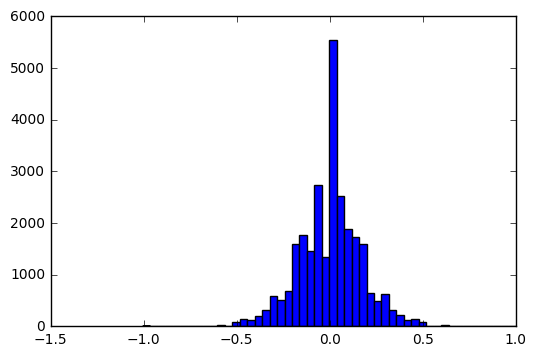

In [88]:
import time
start = time.time()

# Load training data
df = pd.read_csv(os.path.join(data_folder, 'driving_log.csv'))
df_aug = pd.DataFrame(index=df.index)
# for index, row in df.iterrows():
#     img = mpimg.imread(os.path.join(data_folder, row['center']))
#     img = img[np.newaxis, ...]
#     images.append(img)

X_train = np.concatenate(images, axis=0)
y_train = df['steering'].values

# Mirror Images
turn_indexes = ([i for i,v in enumerate(y_train) if v != 0])
augmented = []
augmented_angles = []

for j in range(1000):
    index = np.random.choice(turn_indexes)
    mirror = bool(random.randint(0,1))
    perturb = bool(random.randint(0,1))
    brighten = bool(random.randint(0,1))
    
    path = df.iloc[index]['center']
    image = mpimg.imread('data/udacity_data/' + path)
    angle = df.iloc[index]['steering']
    
    if mirror:
        image, angle = mirror_image(image, angle)
    if perturb:
        angle = perturb_angle(perturb)
    if brighten:
        image = augment_brightness(image)
    
    image = image[np.newaxis, ...]
    augmented.append(image)
    augmented_angles.append(angle)

offset = 0
for i, image in enumerate(augmented):
    # restart here

end = time.time()

y_augmented = np.concatenate((y_train, np.array(augmented_angles)), axis=0)
plt.hist(y_augmented, bins=50)
print(X_augmented.shape)
print(y_augmented.shape)
print("Execution Time (secs):", end - start)

In [89]:
print(X_augmented.nbytes // 2**20)

4059


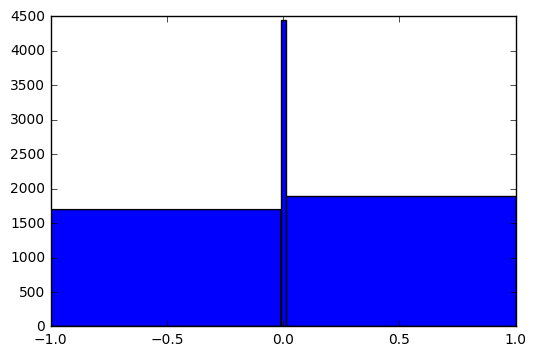

In [39]:
if flags['show_plots']:
    plt.hist(y_train, bins=[-1, -.01, .01, 1])

#### Plots

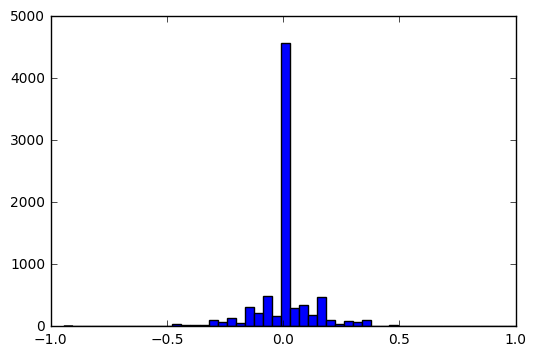

In [41]:
if flags['show_plots']:
    plt.hist(y_train, bins=50)

In [37]:
if flags['show_plots']:
    plt.figure(figsize=(16,5))
    plt.plot(y_train[0:1000])

#### Balance Dataset

## Setup and Train Network

In [41]:
model = Sequential()


model.add(Convolution2D(48, 11, 11, subsample=(4,4), input_shape=(160, 320, 3))) # 38 x 78
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) # 18 x 38


model.add(Convolution2D(256, 5, 5)) # 16 x 36
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2))) # 8 x 18

model.add(Convolution2D(384, 3, 3, border_mode='same')) # 8 x 18
model.add(Activation('relu'))

model.add(Convolution2D(384, 3, 3, border_mode='same')) # 8 x 18
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3, border_mode='same')) # 8 x 18
model.add(Activation('relu'))
model.add(MaxPooling2D((2,3))) # 4 x 6

model.add(Flatten())
model.add(Dense(3072))
model.add(Dense(3072))
model.add(Dense(1))

In [42]:
if flags['train_model']:
    model.compile('adam', 'mse')
    model.fit(X_train, y_train, nb_epoch=8, batch_size=128, validation_split=.2)
    model.save('model.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/8
6428/6428 [==============================] - 53s - loss: 1.7178 - val_loss: 0.0178
Epoch 2/8
6428/6428 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0172
Epoch 3/8
6428/6428 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0166
Epoch 4/8
6428/6428 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0164
Epoch 5/8
6428/6428 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0164
Epoch 6/8
6428/6428 [==============================] - 40s - loss: 0.0168 - val_loss: 0.0170
Epoch 7/8
6428/6428 [==============================] - 40s - loss: 0.0170 - val_loss: 0.0165
Epoch 8/8
6428/6428 [==============================] - 40s - loss: 0.0172 - val_loss: 0.0165
